# Look at hyperoptimization results for BioWTA on vowel data, when optimizing `n_features`

In [1]:
import h5py
import gc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from typing import Sequence, Union, Tuple, Optional

from tqdm.notebook import tqdm
from bioslds.hdf import read_namespace_hierarchy
from bioslds.plotting import FigureManager, colorbar

paper_style = [
    "seaborn-paper",
    {"font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 6, "ytick.labelsize": 6},
]

## Useful definitions

In [2]:
def make_two_param_plot(
    ax: plt.Axes,
    values: dict,
    key1: str,
    key2: str,
    log1: bool = False,
    log2: bool = False,
    mask: Union[None, slice, Sequence] = None,
    fct_key: str = "fct",
    vmin: float = 0.5,
    vmax: float = 1.0,
):
    # make the scatter plot
    if mask is None:
        mask = slice(None, None)
    h = ax.scatter(
        values[key1][mask],
        values[key2][mask],
        c=values[fct_key][mask],
        cmap="Reds",
        vmin=vmin,
        vmax=vmax,
        alpha=0.3,
        ec=None,
    )

    ax.set_xlabel(key1)
    ax.set_ylabel(key2)

    if log1:
        ax.set_xscale("log")
    if log2:
        ax.set_yscale("log")

    ax.set_xlim(np.min(all_values[key1]), np.max(all_values[key1]))
    ax.set_ylim(np.min(all_values[key2]), np.max(all_values[key2]))

    colorbar(h)

In [3]:
def make_summary_figure(
    values: dict,
    fct_key: str = "fct",
    top_fraction: float = 0.01,
    log_scale: Optional[Sequence] = None,
    vmin: float = 0.5,
    vmax: float = 1.0,
) -> Tuple[plt.Figure, Sequence]:
    if log_scale is None:
        log_scale = []

    # keep only the keys that have some variation and are not scores
    keys = [
        key
        for key in values.keys()
        if not key.startswith("fct") and np.std(values[key]) > 0
    ]

    # identify the top 5% highest scores
    scores = values[fct_key]

    n = len(scores)
    n_highscore = max(1, int(np.round(top_fraction * n)))
    highscore_idxs = np.argsort(scores)[-n_highscore:]
    highscores = scores[highscore_idxs]

    # make the figure
    n_keys = len(keys)
    with plt.style.context(paper_style):
        with FigureManager(
            n_keys,
            n_keys,
            squeeze=False,
            figsize=(9, 3 * 9 / 4),
            despine_kws={"offset": 5},
        ) as (fig, axs):
            # draw histograms on the diagonal
            for i in range(n_keys):
                ax = axs[i, i]

                crt_values = values[keys[i]]
                sns.histplot(
                    crt_values,
                    element="step",
                    stat="density",
                    alpha=0.2,
                    color="gray",
                    log_scale=keys[i] in log_scale,
                    label="all",
                    ax=ax,
                )

                # now draw the high-scoring values
                crt_highscore_values = crt_values[highscore_idxs]
                sns.kdeplot(
                    crt_highscore_values,
                    color="C1",
                    log_scale=keys[i] in log_scale,
                    shade=True,
                    label=f"best {int(top_fraction * 100)}%",
                    ax=ax,
                )
                sns.rugplot(
                    crt_highscore_values, height=0.05, c="C1", lw=0.5, ax=ax,
                )

                ax.legend(frameon=False, fontsize=6, loc="upper left")
                ax.set_xlabel(keys[i])
                ax.set_ylabel("pdf")

                ax.set_xlim(np.min(crt_values), np.max(crt_values))

            # now the off-diagonals
            for i in range(n_keys):
                crt_values1 = values[keys[i]]
                crt_highscore_values1 = crt_values1[highscore_idxs]
                for j in range(n_keys):
                    if j == i:
                        continue

                    crt_values2 = values[keys[j]]
                    crt_highscore_values2 = crt_values2[highscore_idxs]

                    ax = axs[j, i]

                    h = ax.scatter(
                        crt_values1,
                        crt_values2,
                        c=scores,
                        cmap="Greys",
                        vmin=vmin,
                        vmax=vmax,
                        alpha=0.2,
                        ec=None,
                    )

                    # now the high-scoring set
                    h = ax.scatter(
                        crt_highscore_values1,
                        crt_highscore_values2,
                        c=highscores,
                        cmap="Reds",
                        vmin=vmin,
                        # vmax=np.max(highscores),
                        alpha=0.7,
                        ec=None,
                    )

                    ax.set_xlabel(keys[i])
                    ax.set_ylabel(keys[j])

                    if keys[i] in log_scale:
                        ax.set_xscale("log")
                    if keys[j] in log_scale:
                        ax.set_yscale("log")

                    ax.set_xlim(np.min(crt_values1), np.max(crt_values1))
                    ax.set_ylim(np.min(crt_values2), np.max(crt_values2))

    return fig, axs

In [4]:
def make_optimal_parameter_figure(
    values: dict,
    fct_key: Union[str, Sequence] = "fct",
    top_fraction: float = 0.01,
    log_scale: Optional[Sequence] = None,
) -> Tuple[plt.Figure, Sequence]:
    if log_scale is None:
        log_scale = []

    if isinstance(fct_key, str):
        fct_key = [fct_key]

    # keep only the keys that have some variation and are not scores
    keys = [
        key
        for key in values.keys()
        if not key.startswith("fct") and np.std(values[key]) > 0
    ]

    # make the figure
    n_keys = len(keys)
    with FigureManager(n_keys, len(fct_key), squeeze=False) as (fig, axs):
        for k, crt_key in enumerate(fct_key):
            ax_col = axs[:, k]

            scores = values[crt_key]
            n = len(scores)
            n_highscore = max(1, int(np.round(top_fraction * n)))

            score_order = np.argsort(scores)[::-1]
            ordered_scores = scores[score_order]
            score_estimate = np.cumsum(ordered_scores) / np.arange(1, n + 1)

            for i in range(n_keys):
                ax = ax_col[i]

                crt_values = values[keys[i]]

                if keys[i] not in log_scale:
                    crt_cum_estimate = np.cumsum(crt_values[score_order]) / np.arange(
                        1, n + 1
                    )
                else:
                    crt_cum_estimate = np.exp(
                        np.cumsum(np.log(crt_values[score_order])) / np.arange(1, n + 1)
                    )

                ax.plot(score_estimate, crt_cum_estimate)

                ax.set_xlabel(f"average score ({crt_key})")
                ax.set_ylabel(keys[i])

                if keys[i] in log_scale:
                    ax.set_yscale("log")

                # annotate the `top_fraction` estimate
                crt_len = 0.25 * np.diff(ax.get_xlim())[0]
                crt_top_estimate = crt_cum_estimate[n_highscore]
                ax.plot(
                    np.asarray([-crt_len, 0]) + 2 * [ax.get_xlim()[1]],
                    2 * [crt_top_estimate],
                    "--",
                    c="C1",
                    label=f"best {keys[i]} = {crt_top_estimate:.3g}",
                )

                ax.legend(frameon=False)

                ax_col[0].set_title(crt_key)
                
                ax.set_ylim(np.min(crt_values), np.max(crt_values))

    return fig, axs

## Data loading

In [5]:
quantile_choice = 0.05
# good_threshold = 0.85
good_threshold = 0.70

start_seed = 800
n_seeds = 40
batch_path = os.path.join("..", "..", "batch", "biowta_vowels_ao_long_n_feat")

results = {"fct": [], "fct_quantile": [], "fct_good": []}
for crt_seed in tqdm(range(start_seed, start_seed + n_seeds)):
    # load the data
    fname = os.path.join(batch_path, f"test_{crt_seed}.hdf5")
    with h5py.File(fname, "r") as f:
        crt_res = read_namespace_hierarchy(f)

    # initialize parameter lists
    if crt_seed == start_seed:
        results.update({key: [] for key in crt_res["params"][0].keys()})

    # process and keep the relevant parts of the data
    for key in results:
        if key not in ["fct", "fct_quantile", "fct_good"]:
            crt_values = [_[key] for _ in crt_res["params"]]
            results[key].extend(crt_values)

    # now update some special values:
    # median scrore
    results["fct"].extend(crt_res["fct_scalar"])

    # quantile score
    for crt_eval in crt_res["fct_full"]:
        crt_quant = np.quantile(crt_eval[1].trial_scores, quantile_choice)
        results["fct_quantile"].append(crt_quant)

    # fraction of "good" runs
    for crt_eval in crt_res["fct_full"]:
        crt_good = np.mean(crt_eval[1].trial_scores >= good_threshold)
        results["fct_good"].append(crt_good)

# ensure everything is a Numpy array
for key in results:
    results[key] = np.asarray(results[key])

# don't keep too much useless stuff in memory
del f
del crt_res
del crt_eval
_ = gc.collect()

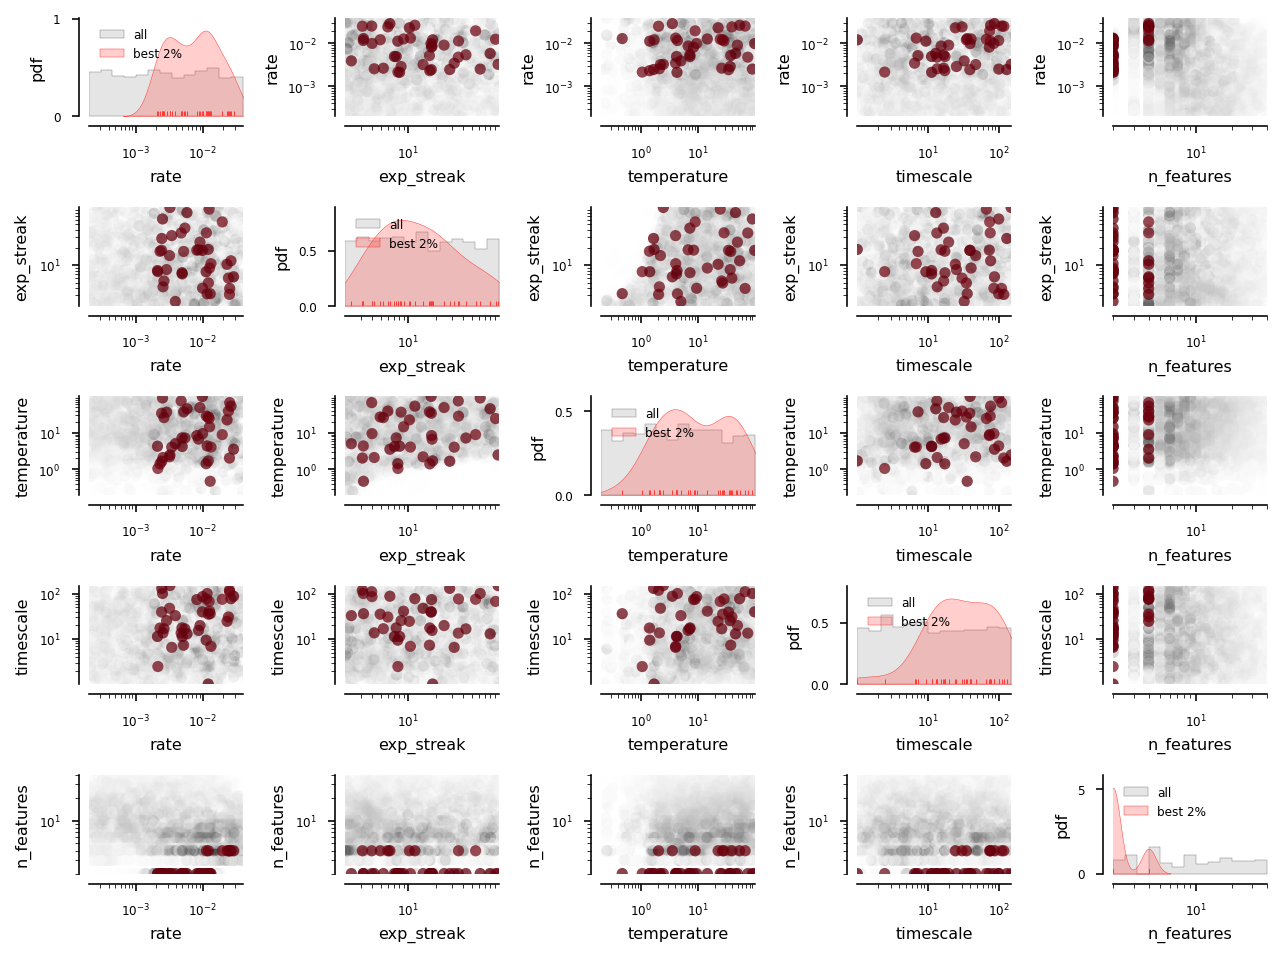

In [6]:
fig, _ = make_summary_figure(
    results,
    log_scale=["rate", "exp_streak", "temperature", "timescale", "n_features"],
    fct_key="fct_good",
    vmin=0.0,
    vmax=1.0,
    top_fraction=0.02,
)

In [7]:
summary = pd.DataFrame()
# summary["mod_key"] = configurations_human.keys()
summary["mod_name"] = ["biowta"]

for fct_type in ["fct", "fct_quantile", "fct_good"]:
    summary[f"best_{fct_type}"] = [np.max(results[fct_type])]

keys = [
    key
    for key in results.keys()
    if not key.startswith("fct") and np.std(results[key]) > 0
]
chosen_fct = "fct_good"
for key in keys:
    if not key.startswith("fct"):
        key_values = []
        crt_idx = np.argmax(results[chosen_fct])
        key_values.append(results[key][crt_idx])

        summary[f"{key}_at_best_{chosen_fct}"] = key_values

In [8]:
summary

,mod_name,best_fct,best_fct_quantile,best_fct_good,rate_at_best_fct_good,exp_streak_at_best_fct_good,temperature_at_best_fct_good,timescale_at_best_fct_good,n_features_at_best_fct_good
0,biowta,0.89096,0.832612,1.0,0.003216,14.562668,2.209786,47.506955,2
